# Тема: Сегментация

### 1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Можете взять один из этих наборов данных:
- https://www.kaggle.com/carlolepelaars/camvid

In [30]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import cv2

import keras
import keras.backend as K
from keras.preprocessing import image
from keras.layers import Activation, Input, MaxPooling2D, BatchNormalization, Conv2D, Conv2DTranspose, UpSampling2D, concatenate
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications import VGG16

from tensorflow.keras.utils import plot_model

from IPython.display import clear_output

In [4]:
path_imgs = 'data/CamVid/test/'
path_masks = 'data/CamVid/test_labels/'

imgs_paths = list(Path(path_imgs).iterdir())
masks_paths = list(Path(path_masks).iterdir())

In [6]:
# загружаем данные
images = []
masks = []
image_size = (int(image.load_img(imgs_paths[0]).size[1]/2), int(image.load_img(imgs_paths[0]).size[0]/2))

for i_img in imgs_paths[0:100]:
    images.append(image.load_img(i_img, target_size=image_size))
    for i_mask in masks_paths:
        if i_img.name[0:-4] == i_mask.name[0: -6]:
            masks.append(image.load_img(i_mask, target_size=image_size))
            
df = pd.read_csv('data/CamVid/class_dict.csv')

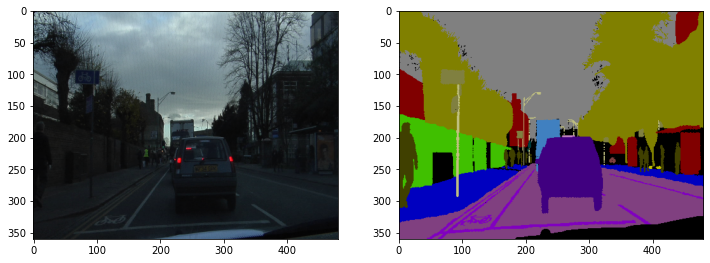

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(images[80].convert('RGBA'))
ax[1].imshow(masks[80].convert('RGBA'))

In [8]:
# создаем обучающую выборку
X = []

for img in images:
    x = image.img_to_array(img)
    X.append(x)

X = np.array(X)
print(X.shape)

(100, 360, 480, 3)


In [9]:
# датасет цветов воспринимаемого диапазона для сегментированной картинки
df.head()

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0


In [10]:
# Делаем конвертер в one-hot_encoding для выходных примеров
def Color2index(y):
    arr_col = np.array(df[['r', 'g', 'b']])

    y_ind = np.zeros((y.shape[0], y.shape[1]))
    y_cat = np.zeros((y.shape[0], y.shape[1], len(arr_col)))
    i = 1
    for i_color in arr_col:
        ind_i = np.where(
            (y[..., 0] == i_color[0]) 
            & (y[..., 1] == i_color[1])
            & (y[..., 2] == i_color[2])
        )
        y_ind[ind_i[0], ind_i[1]] = i
        y_cat[ind_i[0], ind_i[1], i-1] = 1 
        i += 1
    
    return y_cat, y_ind

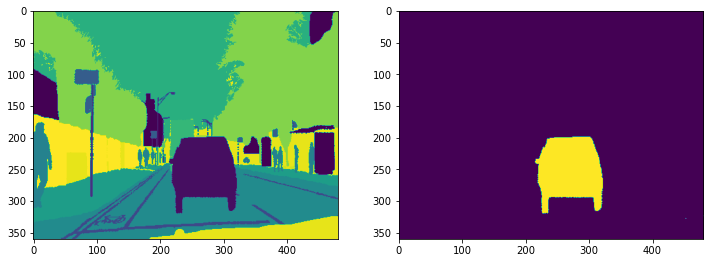

In [11]:
cat_yi, ind_yi = Color2index(image.img_to_array(masks[80]))

fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(ind_yi)
ax[1].imshow(cat_yi[..., 5])

In [12]:
# Сегментированные картинки в One hot encoding (разметка на 32 класса)
y = []

for mask in masks:
    y_cat, _ = Color2index(image.img_to_array(mask))
    y.append(y_cat)

y = np.array(y)
print(y.shape)

(100, 360, 480, 32)


In [13]:
# Делим на тест и трейн по числу N
N = 70
y_train = y[:N, ...]
X_train = X[:N, ...]

y_test = y[N:, ...]
X_test = X[N:, ...]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((70, 360, 480, 3), (70, 360, 480, 32), (30, 360, 480, 3), (30, 360, 480, 32))

In [14]:
# функция коэффициента DICE
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

### U-net

In [15]:
# Создаём и обучаем U-net
def Unet(num_classes=14, input_shape=(360, 480, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)


    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)


    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)


    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

 
    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

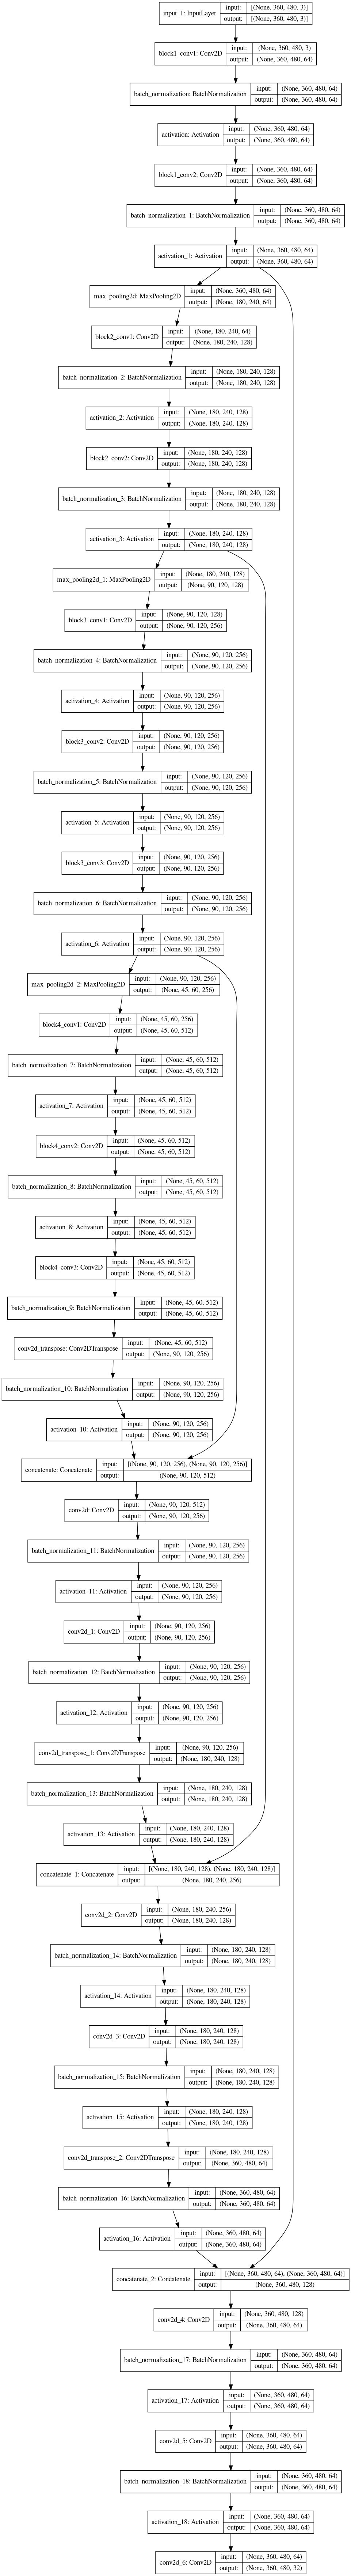

In [16]:
model_1 = Unet(32, (360, 480, 3))

plot_model(model_1, to_file='models/camvid_model_1.png', show_shapes=True)

In [17]:
model_1.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 360, 480, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 360, 480, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 360, 480, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 360, 480, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [22]:
# функции Callback
sample_image = X_test[10]
sample_mask = y_test[10]

def show_predictions(model):
    pred_mask = model.predict(sample_image[None])[..., 5]
    print(pred_mask.shape)

    fig, ax = plt.subplots(1, 3, figsize=(15, 8))

    ax[0].imshow(sample_image / 255.0)
    ax[1].imshow(sample_mask[..., 5])
    ax[2].imshow(np.squeeze(pred_mask, axis=0))
    plt.show()


class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, patience=1):
        super().__init__()
        self.patience = patience
    
    def on_train_begin(self, logs=None):
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        self.wait += 1
        if self.wait >= self.patience:
            clear_output(wait=True)
            show_predictions(self.model)
            print(f'\nSample Prediction after epoch {epoch+1}')
            self.wait = 0

(1, 360, 480)


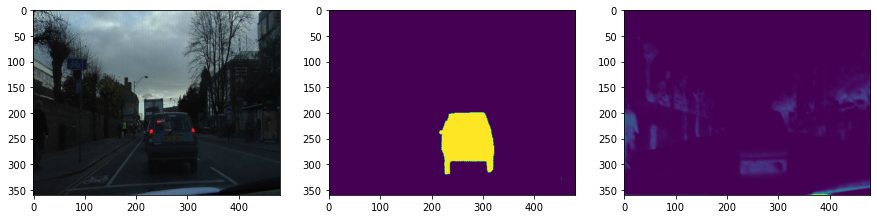

In [23]:
show_predictions(model_1)

(1, 360, 480)


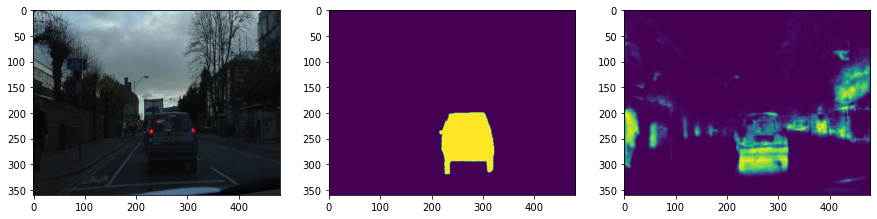


Sample Prediction after epoch 10


In [24]:
history = model_1.fit(X_train, y_train,
                      epochs=10,
                      batch_size=1,
                      validation_data=(X_test, y_test),
                      callbacks=[DisplayCallback(patience=5)])

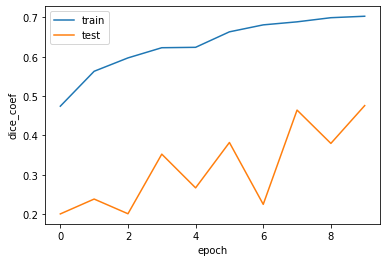

In [25]:
plt.plot(history.history['dice_coef'], label='train')
plt.plot(history.history['val_dice_coef'], label='test')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [26]:
pred = model_1.predict(X_test)
print(pred.shape)

(30, 360, 480, 32)


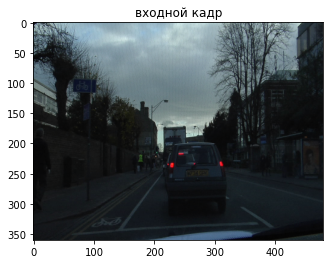

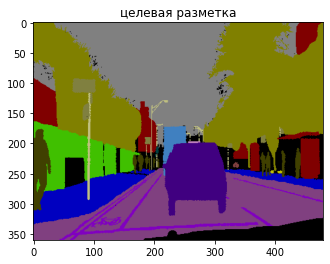

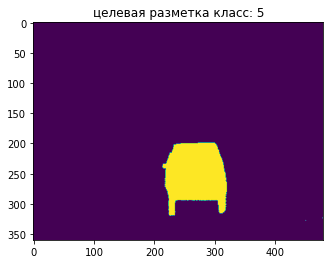

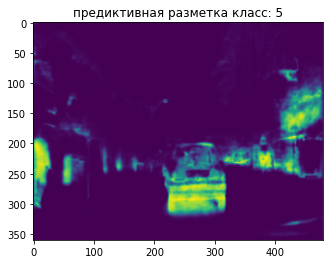

In [28]:
n = 10
class_ = 5
plt.imshow(images[N + n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(masks[N + n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = y_test[n][..., class_]
plt.imshow(img)
plt.title('целевая разметка класс: ' + str(class_))
plt.show()
img = pred[n][..., class_]
plt.imshow(img)
plt.title('предиктивная разметка класс: ' + str(class_))
plt.show()

### Претренированная  U-Net

In [31]:
# Претренированная  U-Net
pre_trained_model = VGG16(input_shape=X_test.shape[1:], include_top=False, weights='imagenet')

58892288/58889256 [==============================] - 5s 0us/step


In [32]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 360, 480, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 360, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 360, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 180, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 180, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 180, 240, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 90, 120, 128)      0     

In [33]:
def unet_pre_train(num_classes=32, input_shape=(360, 480, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')

    for layer in pre_trained_model.layers[:-5]:
        layer.trainable = False

    x = pre_trained_model.layers[13].output
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
   
    # UP 1

    # добавили перенос из VGG16
    x = concatenate([x, block_4_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из VGG16
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из VGG16
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

KerasTensor(type_spec=TensorSpec(shape=(None, 45, 60, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 90, 120, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 180, 240, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")


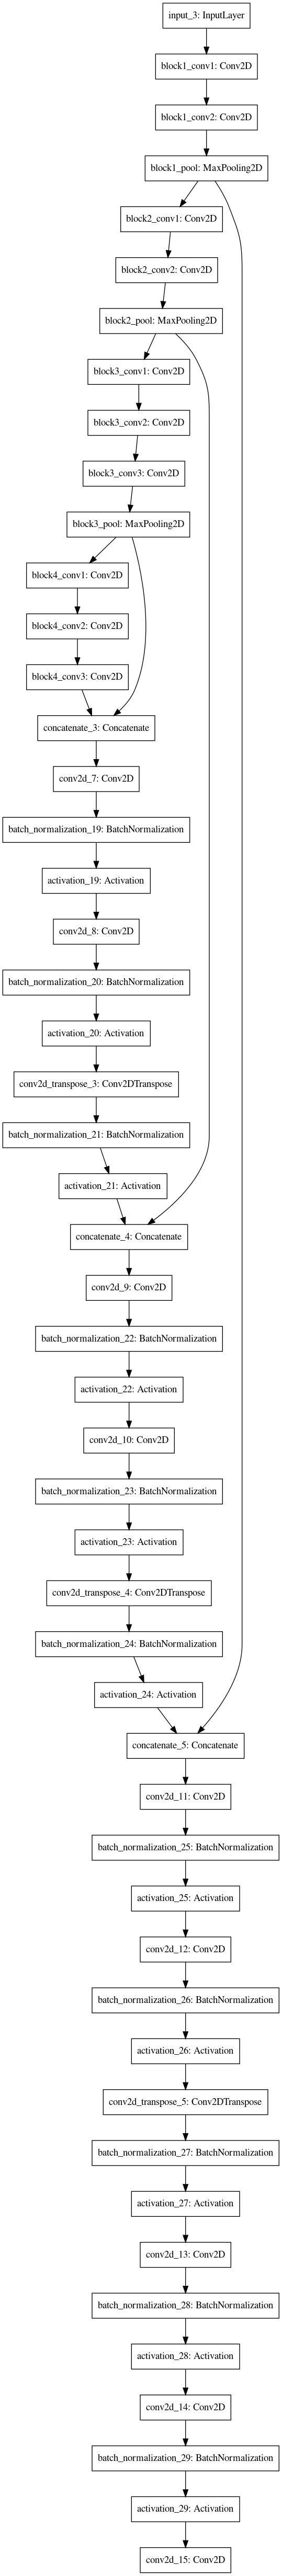

In [34]:
model_2 = unet_pre_train(num_classes=32, input_shape=(360, 480, 3))

plot_model(model_2, to_file='models/camvid_model_2.png')

In [35]:
model_2.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 360, 480, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 360, 480, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 360, 480, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 180, 240, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

(1, 360, 480)


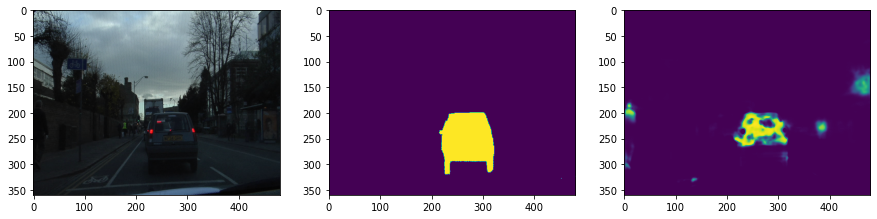


Sample Prediction after epoch 10


In [36]:
history = model_2.fit(X_train, y_train,
                      epochs=10,
                      batch_size=1,
                      validation_data=(X_test, y_test),
                      callbacks=[DisplayCallback(patience=5)])

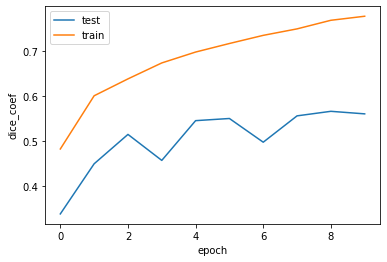

In [37]:
plt.plot(history.history['val_dice_coef'], label='test')
plt.plot(history.history['dice_coef'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [38]:
pred = model_2.predict(X_test)
print(pred.shape)

(30, 360, 480, 32)


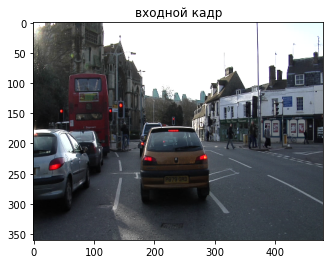

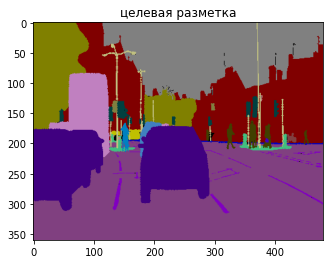

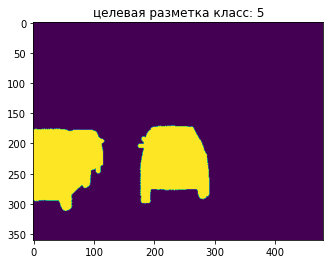

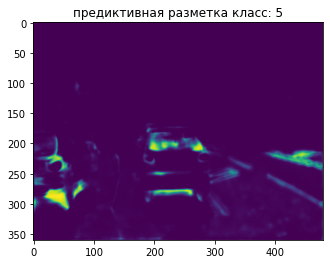

In [39]:
n = 1
class_ = 5
plt.imshow(images[N + n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(masks[N + n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = y_test[n][..., class_]
plt.imshow(img)
plt.title('целевая разметка класс: ' + str(class_))
plt.show()
img = pred[n][..., class_]
plt.imshow(img)
plt.title('предиктивная разметка класс: ' + str(class_))
plt.show()